## Лабораторная работа 9.
### Анализ шума

ФИО: Монастырный Максим Александрович

Группа: М24-501 

In [1]:
import wave
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
data_dir = Path("../data/audio")
audio_path = data_dir / "ocarina.wav"

Функции IO

In [4]:
def read_wav(path: Path):
    """
    Read a WAV file and return mono audio signal, sample rate, and number of channels.

    Args:
        path (Path): Path to the WAV file.

    Returns:
        x_mono (np.ndarray): Mono audio signal as a float32 numpy array in range [-1.0, 1.0].
        sr (int): Sample rate of the audio.
        n_channels (int): Number of channels in the original audio.
    """
    with wave.open(path.as_posix(), "rb") as wf:
        n_channels = wf.getnchannels()
        sr = wf.getframerate()
        sampwidth = wf.getsampwidth()
        n_frames = wf.getnframes()
        raw = wf.readframes(n_frames)

    if sampwidth == 1:
        x = np.frombuffer(raw, dtype=np.uint8).astype(np.float32)
        x = (x - 128.0) / 128.0
    elif sampwidth == 2:
        x = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
    elif sampwidth == 3:
        b = np.frombuffer(raw, dtype=np.uint8).reshape(-1, 3)
        x = (
            b[:, 0].astype(np.int32)
            | (b[:, 1].astype(np.int32) << 8)
            | (b[:, 2].astype(np.int32) << 16)
        )
        x = (x ^ (1 << 23)) - (1 << 23)
        x = x.astype(np.float32) / (1 << 23)
    elif sampwidth == 4:
        x = np.frombuffer(raw, dtype=np.int32).astype(np.float32) / 2147483648.0
    else:
        raise ValueError(f"Unsupported sampwidth={sampwidth}")

    x = x.reshape(-1, n_channels)
    if n_channels > 1:
        x_mono = x.mean(axis=1)
    else:
        x_mono = x[:, 0]

    return x_mono.astype(np.float32), int(sr), int(n_channels)


def write_wav_mono16(path: Path, x: np.ndarray, sr: int) -> None:
    """
    Write a mono audio signal to a WAV file in 16-bit PCM format.

    Args:
        path (Path): Path to save the WAV file.
        x (np.ndarray): Mono audio signal as a float32 numpy array in range [-1.0, 1.0].
        sr (int): Sample rate of the audio.
    """
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)

    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(x_i16.tobytes())

Функции для Фурье

In [5]:
def frame_signal(x: np.ndarray, frame_len: int, hop: int) -> np.ndarray:
    """
    Divide a 1D signal into overlapping frames.

    Args:
        x (np.ndarray): Input 1D signal.
        frame_len (int): Length of each frame.
        hop (int): Hop size between frames.

    Returns:
        np.ndarray: 2D array of shape (n_frames, frame_len) containing the framed signal.
    """
    if len(x) < frame_len:
        x = np.pad(x, (0, frame_len - len(x)))
    n_frames = 1 + (len(x) - frame_len) // hop
    shape = (n_frames, frame_len)
    strides = (x.strides[0] * hop, x.strides[0])
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides).copy()


def stft(x: np.ndarray, n_fft: int, hop: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Forward Short-Time Fourier Transform (STFT).

    Args:
        x (np.ndarray): Input 1D signal.
        n_fft (int): FFT size (frame length).
        hop (int): Hop size between frames.

    Returns:
        tuple[np.ndarray, np.ndarray]: STFT matrix and analysis window.
    """
    win = np.hanning(n_fft).astype(np.float32)
    frames = frame_signal(x, n_fft, hop) * win[None, :]
    X = np.fft.rfft(frames, n=n_fft, axis=1)
    return X, win


def istft(
    X: np.ndarray,
    win: np.ndarray,
    hop: int,
    length: int | None = None,
) -> np.ndarray:
    """
    Inverse Short-Time Fourier Transform (iSTFT).

    Args:
        X (np.ndarray): STFT matrix of shape (n_frames, n_bins).
        win (np.ndarray): Synthesis window.
        hop (int): Hop size between frames.
        length (int | None): Desired length of the output signal. If None, returns full length.

    Returns:
        np.ndarray: Reconstructed 1D signal.
    """
    n_frames, n_bins = X.shape
    n_fft = (n_bins - 1) * 2
    x_rec = np.zeros(n_frames * hop + n_fft, dtype=np.float32)
    wsum = np.zeros_like(x_rec)

    for i in range(n_frames):
        frame = np.fft.irfft(X[i], n=n_fft).astype(np.float32)
        start = i * hop
        x_rec[start : start + n_fft] += frame * win
        wsum[start : start + n_fft] += win**2

    nz = wsum > 1e-8
    x_rec[nz] /= wsum[nz]

    if length is not None:
        x_rec = x_rec[:length]
    return x_rec


def mag_db(X: np.ndarray, eps: float = 1e-10) -> np.ndarray:
    """
    Convert magnitude spectrum to decibel (dB) scale.

    Args:
        X (np.ndarray): Input complex STFT matrix.
        eps (float): Small value to avoid log of zero.

    Returns:
        np.ndarray: Magnitude in dB.
    """
    M = np.abs(X)
    return 20.0 * np.log10(np.maximum(M, eps))

Функции для фильтрации

In [6]:
def low_pass_filter(
    signal: np.ndarray,
    sample_rate: int,
    cutoff_hz: float,
    num_taps: int = 1001,
) -> np.ndarray:
    """
    Apply a low-pass FIR filter to the input signal.

    Args:
        signal (np.ndarray): Input 1D signal.
        sample_rate (int): Sample rate of the signal.
        cutoff_hz (float): Cutoff frequency of the low-pass filter in Hz.
        num_taps (int): Number of filter taps (should be odd for linear phase).

    Returns:
        np.ndarray: Filtered signal.
    """
    if signal.ndim != 1:
        raise ValueError("signal must be a one-dimensional array")

    if not 0.0 < cutoff_hz < sample_rate / 2.0:
        raise ValueError("cutoff_hz must be in the range (0, sample_rate/2)")
    if num_taps % 2 == 0:
        num_taps += 1

    fc = cutoff_hz / sample_rate

    n = np.arange(num_taps, dtype=np.float32)
    center = (num_taps - 1) / 2.0

    impulse_response = 2.0 * fc * np.sinc(2.0 * fc * (n - center))

    window = np.hanning(num_taps).astype(np.float32)
    impulse_response *= window

    impulse_response /= np.sum(impulse_response)

    filtered_signal = np.convolve(signal, impulse_response, mode="same")

    return filtered_signal.astype(np.float32)

In [7]:
def wiener_filter_stft(
    signal: np.ndarray,
    sample_rate: int,
    n_fft: int = 4096,
    hop: int = 512,
    quiet_quantile: float = 0.10,
    eps: float = 1e-12,
) -> tuple[np.ndarray, dict]:
    """
    Apply Wiener filtering in the STFT domain to denoise the input signal.

    Args:
        signal (np.ndarray): Input 1D signal.
        sample_rate (int): Sample rate of the signal.
        n_fft (int): FFT size (frame length).
        hop (int): Hop size between frames.
        quiet_quantile (float): Quantile to select quiet frames for noise estimation.
        eps (float): Small value to avoid division by zero.

    Returns:
        tuple[np.ndarray, dict]: Denoised signal and a dictionary with additional info.
    """
    if signal.ndim != 1:
        raise ValueError("signal must be a one-dimensional array")
    if not (0.0 < quiet_quantile < 1.0):
        raise ValueError("quiet_quantile must be in (0, 1)")
    if n_fft <= 0 or hop <= 0:
        raise ValueError("n_fft and hop must be > 0")

    X, win = stft(signal, n_fft=n_fft, hop=hop)
    pxx = (np.abs(X) ** 2).astype(np.float32)

    frames = frame_signal(signal, frame_len=n_fft, hop=hop)
    frame_energy = np.mean(frames**2, axis=1)

    thr = np.quantile(frame_energy, quiet_quantile)
    quiet_idx = np.where(frame_energy <= thr)[0]
    if quiet_idx.size == 0:
        quiet_idx = np.array([int(np.argmin(frame_energy))], dtype=np.int64)

    noise_psd = np.median(pxx[quiet_idx], axis=0).astype(np.float32)

    sxx = np.maximum(pxx - noise_psd[None, :], 0.0)
    gain = sxx / (sxx + noise_psd[None, :] + eps)
    gain = np.clip(gain, 0.0, 1.0).astype(np.float32)

    X_denoised = X * gain
    denoised_signal = istft(X_denoised, win=win, hop=hop, length=len(signal))

    freqs = np.fft.rfftfreq(n_fft, d=1.0 / sample_rate)
    times = (np.arange(X.shape[0]) * hop) / sample_rate

    info = {
        "gain": gain,
        "noise_psd": noise_psd,
        "quiet_idx": quiet_idx,
        "threshold": float(thr),
        "freqs": freqs,
        "times": times,
        "X": X,
        "X_denoised": X_denoised,
    }
    return denoised_signal.astype(np.float32), info

In [8]:
def denoise_signal(
    signal: np.ndarray,
    sample_rate: int,
    # Low-pass stage
    apply_lowpass: bool = True,
    lowpass_cutoff_hz: float = 4000.0,
    lowpass_num_taps: int = 1001,
    # Wiener stage (STFT)
    n_fft: int = 4096,
    hop: int = 512,
    quiet_quantile: float = 0.10,
) -> tuple[np.ndarray, dict]:
    """
    General function: (optionally) Low-pass filter -> Wiener(STFT).

    Args:
        signal: 1D float32 signal.
        sample_rate: Sampling rate (Hz).
        apply_lowpass: Enable low-pass filter before Wiener.
        lowpass_cutoff_hz: Low-pass filter cutoff frequency (Hz).
        lowpass_num_taps: Length of the FIR low-pass filter.
        n_fft: STFT window/FFT size for Wiener.
        hop: STFT hop size.
        quiet_quantile: Fraction of quiet frames for noise estimation.

    Returns:
        denoised: Final signal.
        info: Diagnostics for each stage.
    """
    if signal.ndim != 1:
        raise ValueError("signal must be a one-dimensional array")

    info: dict = {}

    x_in = signal.astype(np.float32, copy=False)

    if apply_lowpass:
        x_lp = low_pass_filter(
            signal=x_in,
            sample_rate=sample_rate,
            cutoff_hz=lowpass_cutoff_hz,
            num_taps=lowpass_num_taps,
        )
        info["lowpass"] = {
            "cutoff_hz": float(lowpass_cutoff_hz),
            "num_taps": int(lowpass_num_taps),
            "rms_before": float(np.sqrt(np.mean(x_in**2))),
            "rms_after": float(np.sqrt(np.mean(x_lp**2))),
        }
        x_stage = x_lp
    else:
        x_stage = x_in
        info["lowpass"] = {"applied": False}

    x_wiener, w_info = wiener_filter_stft(
        signal=x_stage,
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop=hop,
        quiet_quantile=quiet_quantile,
    )

    info["wiener"] = {
        "n_fft": int(n_fft),
        "hop": int(hop),
        "quiet_quantile": float(quiet_quantile),
        "threshold": w_info["threshold"],
        "quiet_frames_count": int(len(w_info["quiet_idx"])),
        "times": w_info["times"],
        "freqs": w_info["freqs"],
        "noise_psd": w_info["noise_psd"],
        "gain": w_info["gain"],
        "X_denoised": w_info["X_denoised"],
    }

    info["rms_final"] = float(np.sqrt(np.mean(x_wiener**2)))
    return x_wiener, info

Дополнительные функции

In [9]:
def plot_spectrogram(
    X: np.ndarray,
    sample_rate: int,
    hop: int,
    title: str = "Spectrogram",
    path: Path = Path("spectrogram.png"),
    peak_tf: list = None,
) -> None:
    """
    Plot the magnitude spectrogram in dB scale.

    Args:
        X (np.ndarray): STFT matrix of shape (n_frames, n_bins).
        sample_rate (int): Sample rate of the signal.
        hop (int): Hop size between frames.
        title (str): Title of the plot.
    """
    n_frames, n_bins = X.shape
    n_fft = (n_bins - 1) * 2

    times = (np.arange(n_frames) * hop) / sample_rate
    freqs = np.fft.rfftfreq(n_fft, d=1.0 / sample_rate)

    M_db = mag_db(X)

    plt.figure(figsize=(21, 10))
    plt.pcolormesh(times, freqs, M_db.T, shading="auto")
    plt.yscale("log")
    plt.ylim(max(20, freqs[1]), sample_rate / 2)
    plt.xlabel("Time, s")
    plt.ylabel("Frequency, Hz (log)")
    plt.title(title)

    if peak_tf is not None:
        tt = [p[1] for p in peak_tf]
        ff = [p[2] for p in peak_tf]
        plt.scatter(tt, ff, marker="x")

    cbar = plt.colorbar()
    cbar.set_label("Magnitude, dB")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.show()

Загрузка аудио

In [10]:
n_fft = 4096
hop = 512

apply_lowpass = True
lowpass_cutoff_hz = 2500.0
lowpass_num_taps = 1001
quiet_quantile = 0.25

In [11]:
x, sr, n_channels = read_wav(audio_path)
t = np.arange(len(x)) / sr

sr, n_channels, len(x), len(x) / sr

(44100, 2, 902016, 20.45387755102041)

In [12]:
x.min(), x.max(), np.sqrt(np.mean(x**2))

(-0.44332886, 0.6057434, 0.041764036)

In [13]:
X, win = stft(x, n_fft=n_fft, hop=hop)
S_db = mag_db(X)

freqs = np.fft.rfftfreq(n_fft, d=(1 / sr))
times = (np.arange(X.shape[0]) * hop) / sr

X.shape, len(freqs), len(times)

((1754, 2049), 2049, 1754)

Рисуем спектрограмму

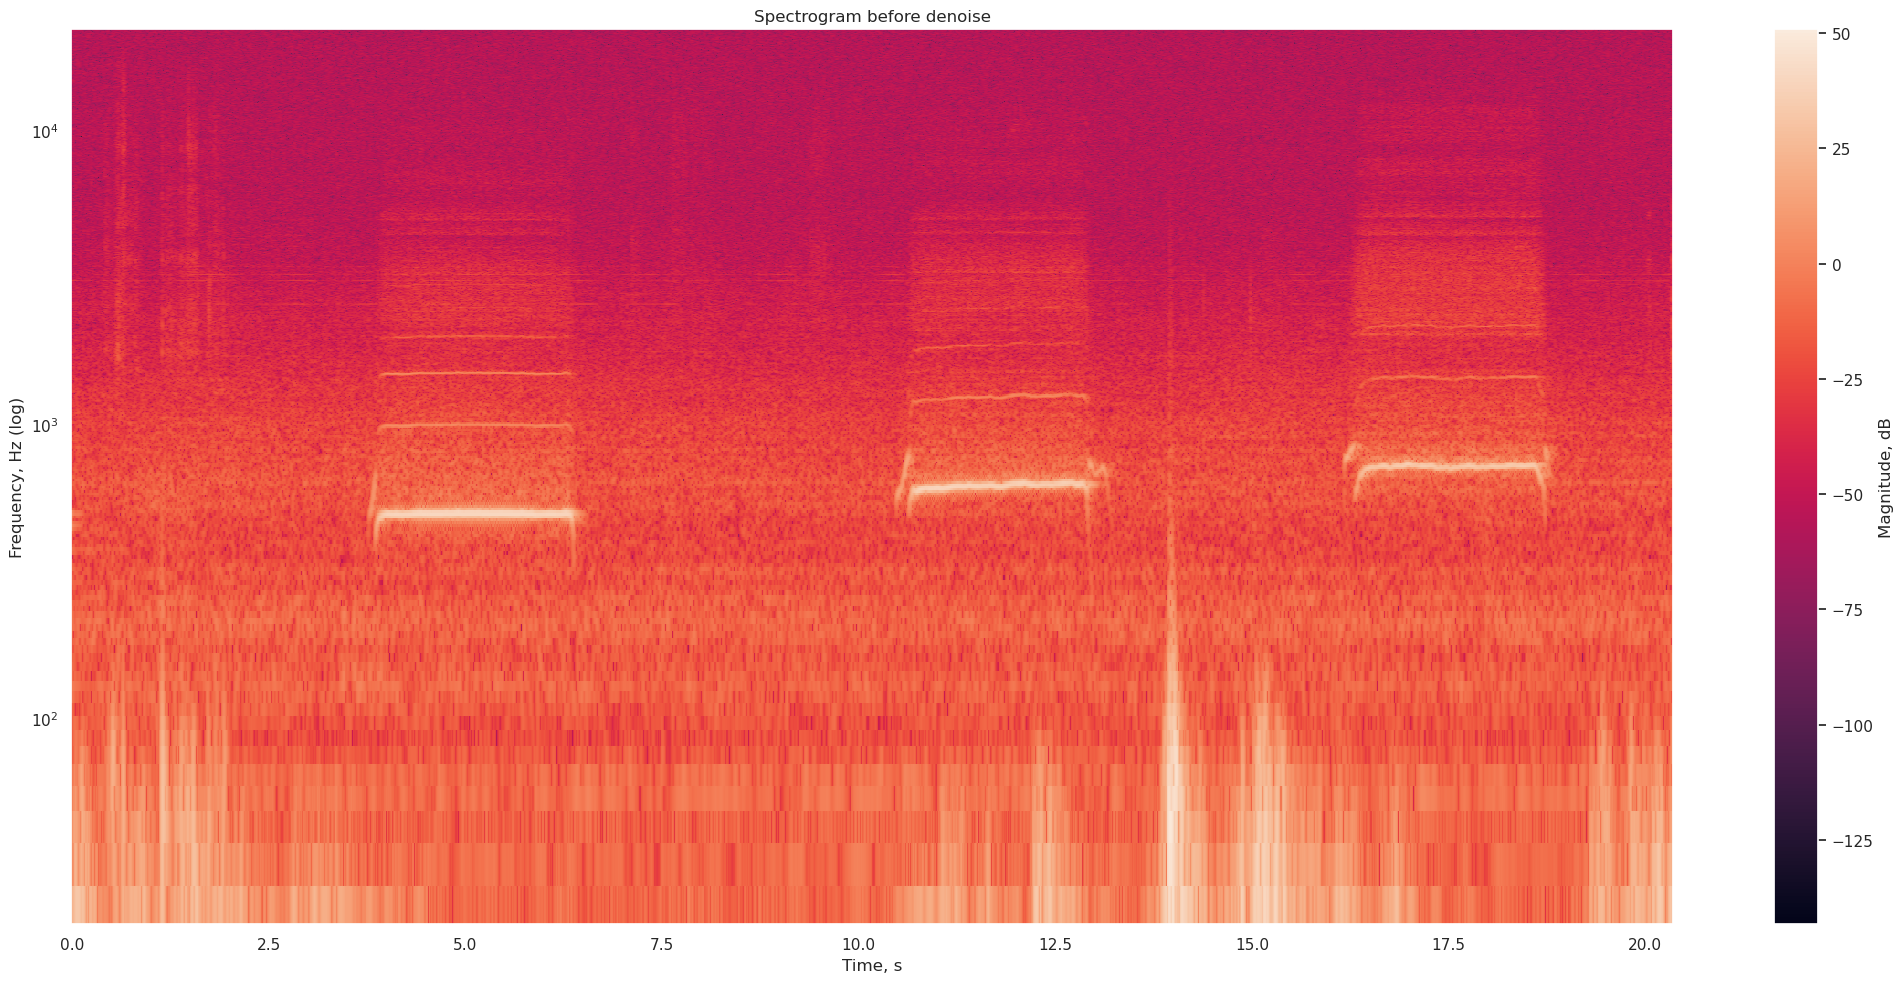

In [14]:
plot_spectrogram(
    X,
    sample_rate=sr,
    hop=hop,
    title="Spectrogram before denoise",
    path=data_dir / "spectrogram_before.png",
)

Убираем шум

In [15]:
x_denoised, denoise_info = denoise_signal(
    signal=x,
    sample_rate=sr,
    apply_lowpass=apply_lowpass,
    lowpass_cutoff_hz=lowpass_cutoff_hz,
    lowpass_num_taps=lowpass_num_taps,
    n_fft=n_fft,
    hop=hop,
    quiet_quantile=quiet_quantile,
)
X_denoised = denoise_info["wiener"]["X_denoised"]

write_wav_mono16(data_dir / "ocarina_denoised.wav", x_denoised, sr)

denoise_info["rms_final"]

0.04198126122355461

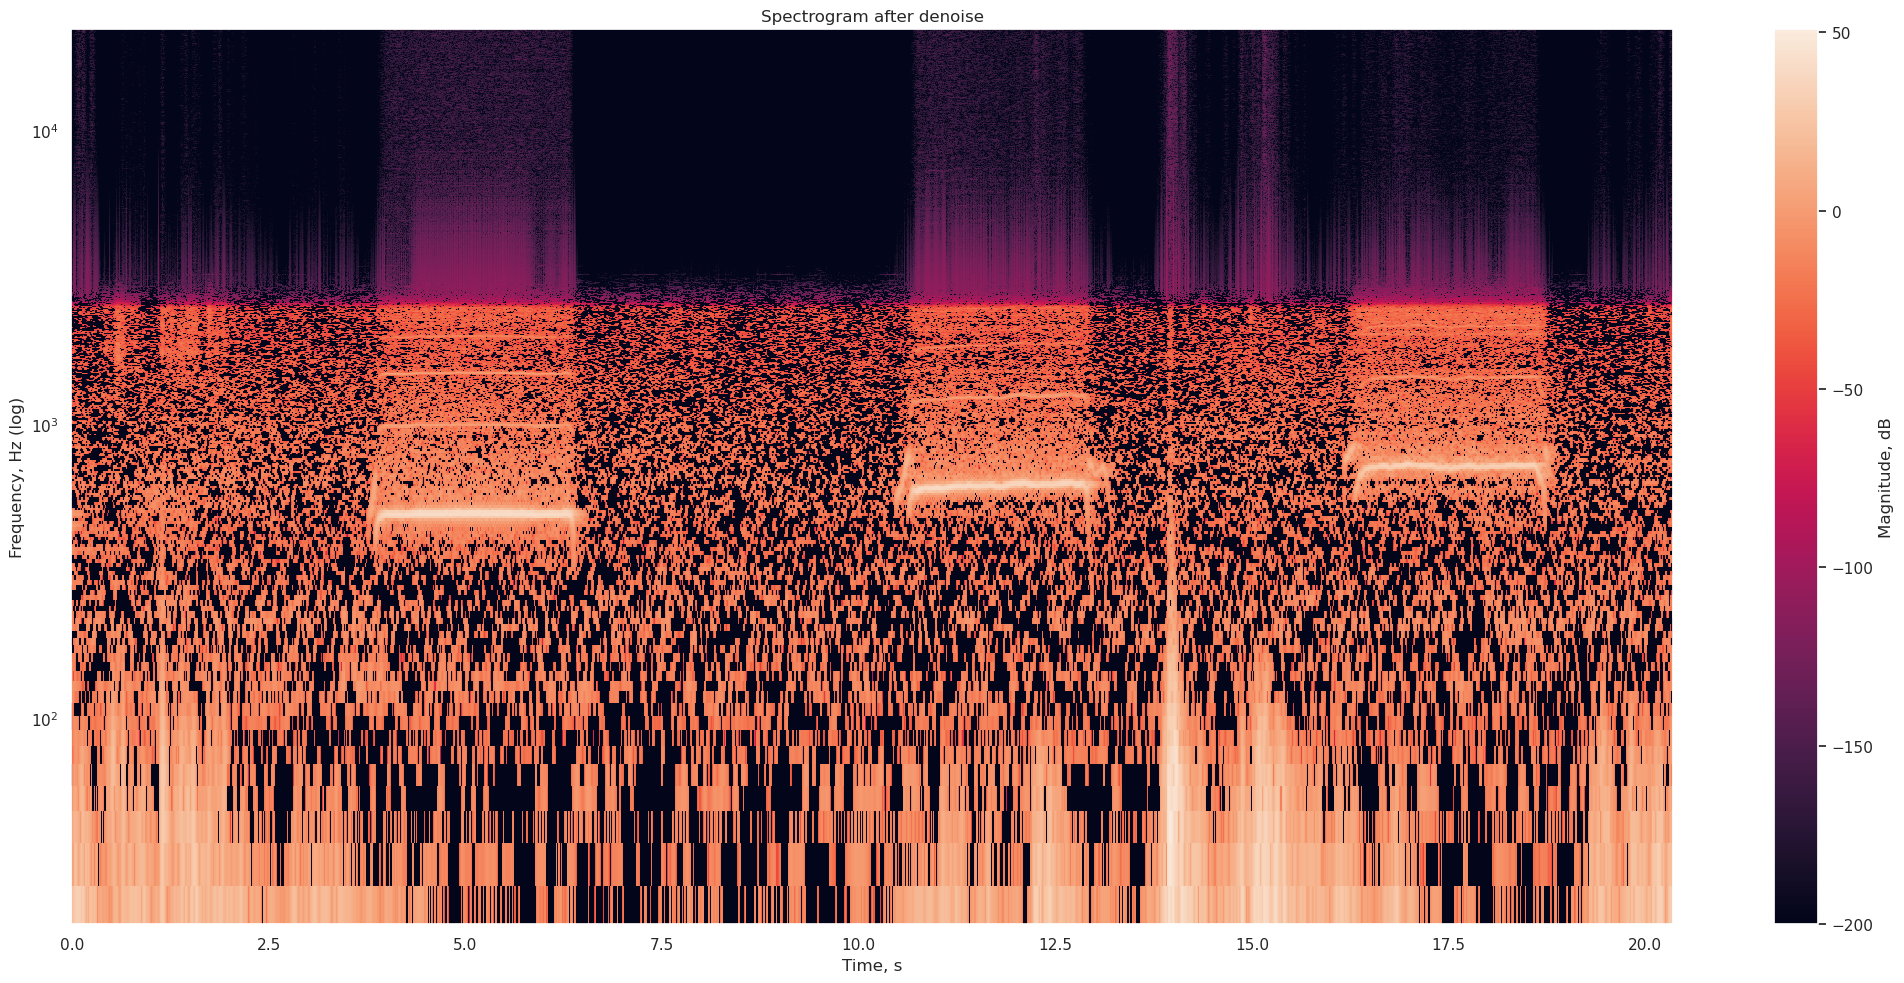

In [16]:
plot_spectrogram(
    X_denoised,
    sample_rate=sr,
    hop=hop,
    title="Spectrogram after denoise",
    path=data_dir / "spectrogram_after.png",
)

Определяем моменты с пиком энергии

In [17]:
dt = 0.1
df = 45.0

top_n = 10

In [18]:
P = (np.abs(X_denoised) ** 2).astype(np.float32)

In [19]:
time_hop_s = hop / sr
t_bins = int(np.round(dt / time_hop_s))
t_bins = max(1, t_bins)

time_hop_s, dt, t_bins

(0.011609977324263039, 0.1, 9)

In [20]:
freq_res = sr / n_fft
f_bins = int(np.round(df / freq_res))
f_bins = max(1, f_bins)

freq_res, df, f_bins

(10.7666015625, 45.0, 4)

In [21]:
kernel_f = np.ones(f_bins, dtype=np.float32) / f_bins
kernel_t = np.ones(t_bins, dtype=np.float32) / t_bins

Pf = np.apply_along_axis(lambda v: np.convolve(v, kernel_f, mode="same"), 1, P)
Ptf = np.apply_along_axis(lambda v: np.convolve(v, kernel_t, mode="same"), 0, Pf)

flat_idx = np.argpartition(Ptf.ravel(), -top_n)[-top_n:]
flat_idx = flat_idx[np.argsort(Ptf.ravel()[flat_idx])[::-1]]

peak_tf = []
for idx in flat_idx:
    ti, fi = np.unravel_index(idx, Ptf.shape)
    peak_tf.append((Ptf[ti, fi], times[ti], freqs[fi], ti, fi))

peak_tf[:3], len(peak_tf)

([(31604.975, 13.978412698412699, 21.533203125, 1204, 2),
  (31427.13, 13.990022675736961, 21.533203125, 1205, 2),
  (30353.092, 13.966802721088435, 21.533203125, 1203, 2)],
 10)

In [22]:
print("Top energy neighborhoods (after denoise):")
for val, tt, ff, ti, fi in peak_tf:
    print(
        f"t={tt:7.3f} s | f={ff:8.1f} Hz | local_energy={val:.3e} | (frame={ti}, bin={fi})"
    )

Top energy neighborhoods (after denoise):
t= 13.978 s | f=    21.5 Hz | local_energy=3.160e+04 | (frame=1204, bin=2)
t= 13.990 s | f=    21.5 Hz | local_energy=3.143e+04 | (frame=1205, bin=2)
t= 13.967 s | f=    21.5 Hz | local_energy=3.035e+04 | (frame=1203, bin=2)
t= 13.955 s | f=    21.5 Hz | local_energy=2.901e+04 | (frame=1202, bin=2)
t= 14.002 s | f=    21.5 Hz | local_energy=2.794e+04 | (frame=1206, bin=2)
t= 13.944 s | f=    21.5 Hz | local_energy=2.757e+04 | (frame=1201, bin=2)
t= 13.978 s | f=    32.3 Hz | local_energy=2.746e+04 | (frame=1204, bin=3)
t= 13.967 s | f=    32.3 Hz | local_energy=2.733e+04 | (frame=1203, bin=3)
t= 13.955 s | f=    32.3 Hz | local_energy=2.684e+04 | (frame=1202, bin=3)
t= 13.990 s | f=    32.3 Hz | local_energy=2.683e+04 | (frame=1205, bin=3)


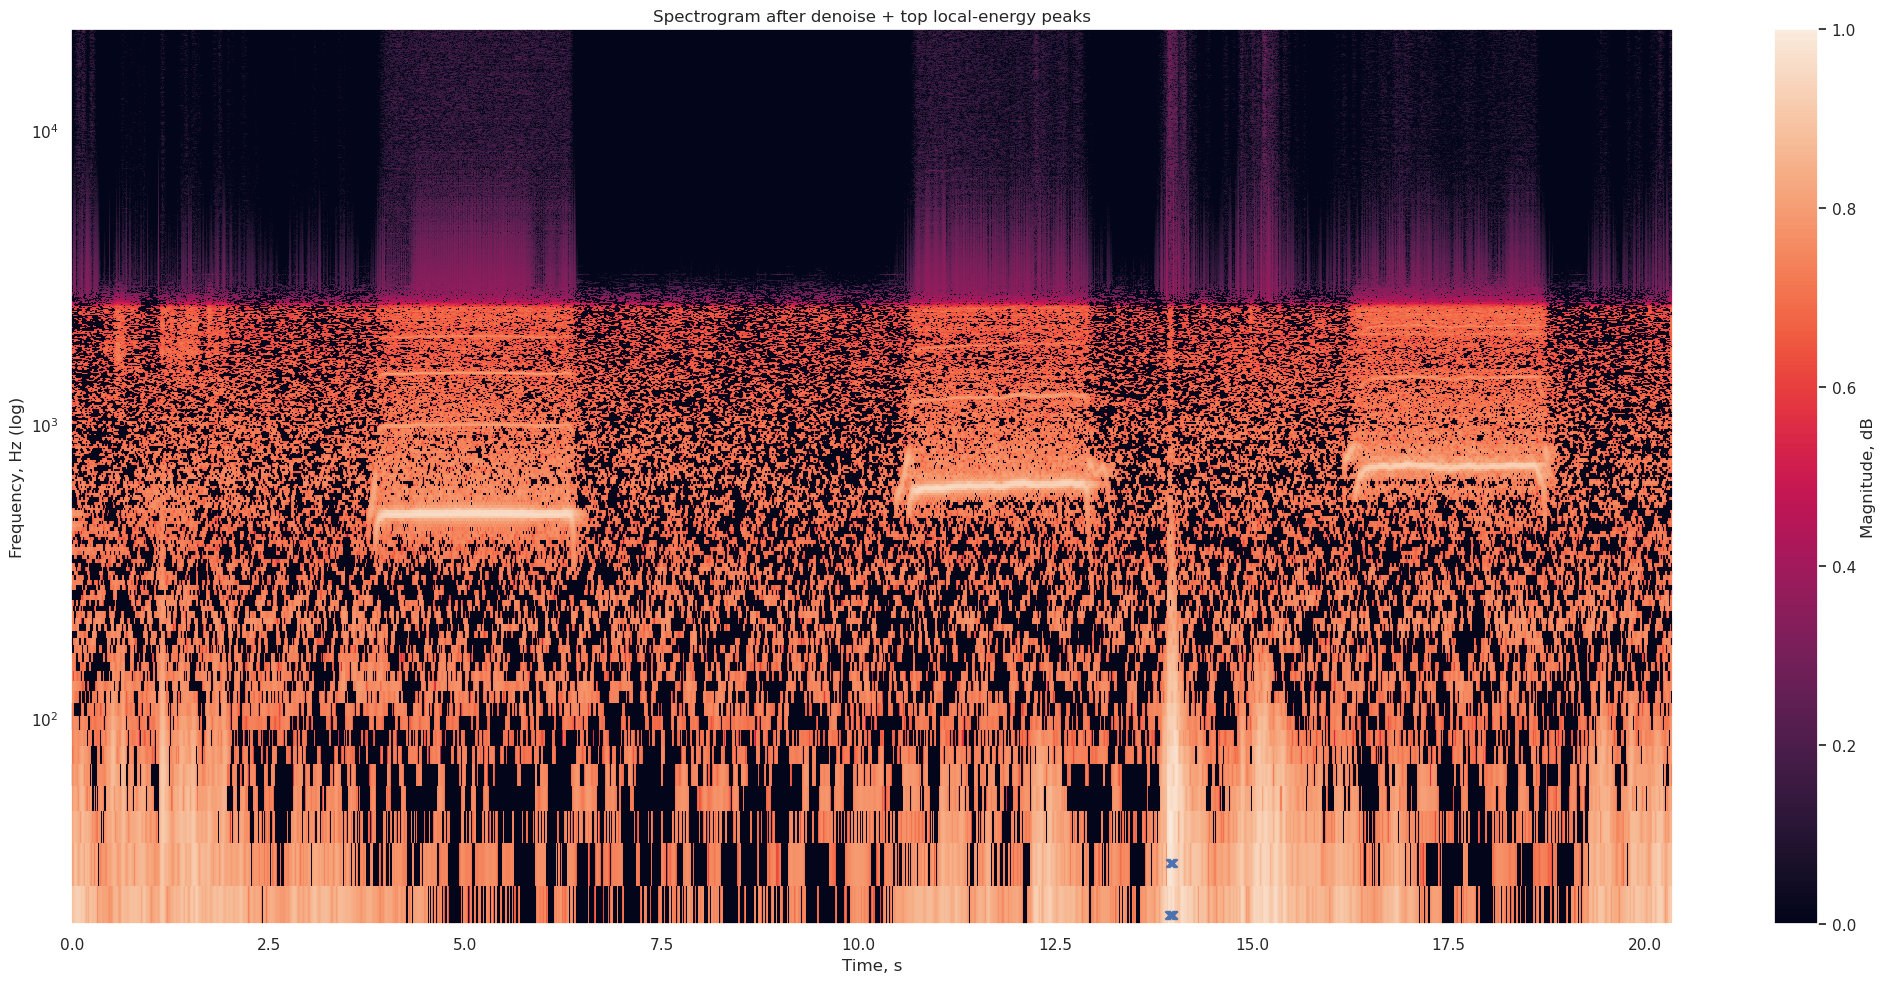

In [23]:
plot_spectrogram(
    X_denoised,
    sample_rate=sr,
    hop=hop,
    title="Spectrogram after denoise + top local-energy peaks",
    path=data_dir / "spectrogram_peaks.png",
    peak_tf=peak_tf,
)

Главный вывод:

Не дышать на микрофон при записи, самое энергичное получается на записи иначе.